# Zoom the satellite_ndvi image to a 5 degree bounding box

* write a new version of modisl1b_reproject called channels_reprojet

* write a new subsample function to clip to the bounding box

* write a new find_corners function to find the box corners of the clipped arrays

* use the %matplotlib notebook backend to pan and zoom

In [1]:
from e582utils.data_read import download

import numpy as np
import h5py
import sys
import warnings
from matplotlib import pyplot as plt
from IPython.display import Image
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize
import matplotlib
import matplotlib.cm as cm
import seaborn as sns
from e582lib.modis_chans import chan_dict
from e582lib.channels_reproject import subsample,find_corners
from e582lib.channels_reproject import resample_channels,write_h5
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
myd02file="MYD021KM.A2016224.2100.006.2016225153002.h5"
download(myd02file)


MYD021KM.A2016224.2100.006.2016225153002.h5 already exists
and is 159039295 bytes
will not overwrite



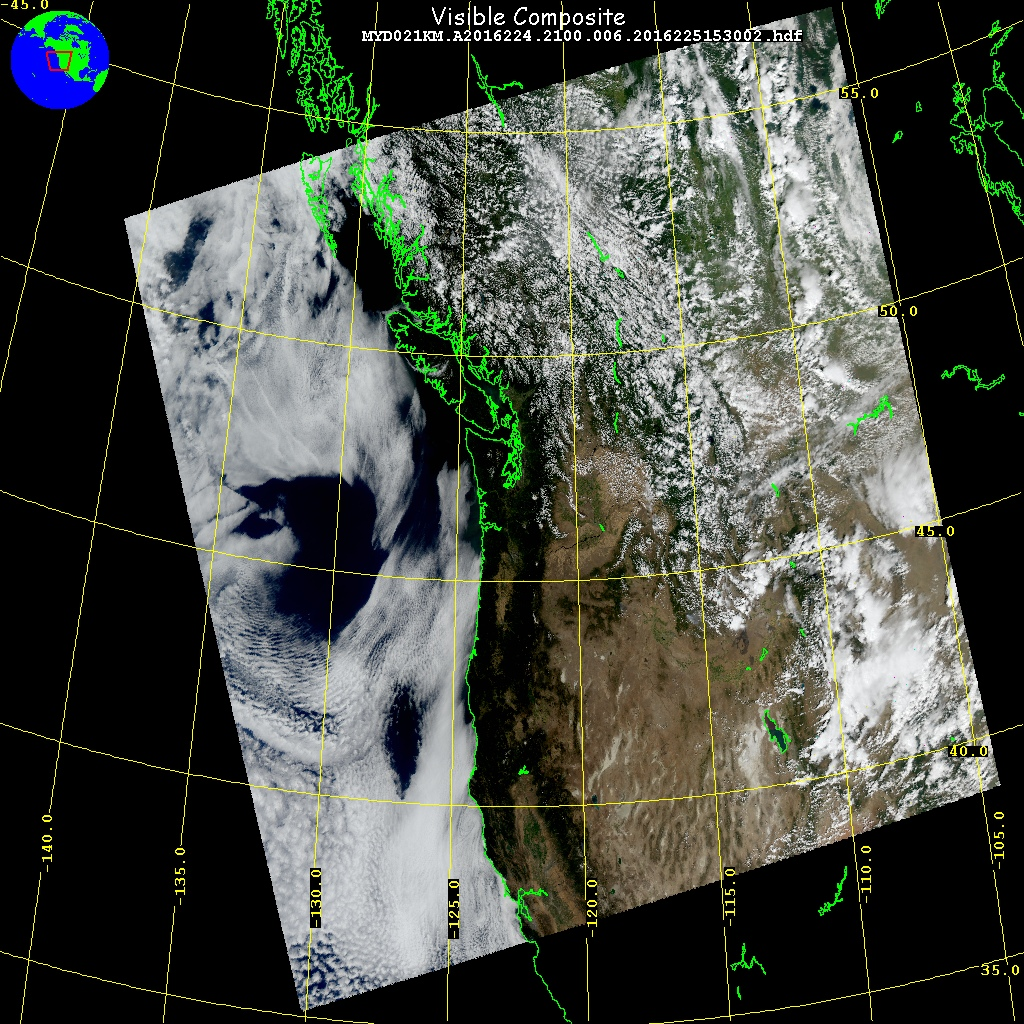

In [2]:
Image('figures/MYBRGB.A2016224.2100.006.2016237025650.jpg')

In [3]:
myd03file="MYD03.A2016224.2100.006.2016225152335.h5"
download(myd03file)


MYD03.A2016224.2100.006.2016225152335.h5 already exists
and is 40795456 bytes
will not overwrite



### Calibrate and resample the channel 1 and channel 2 reflectivities



In [4]:
chan_list=['1','2','3','4']
reflectivity_list=[]
for the_chan in chan_list:
    #
    # read channel channels
    #
    index = chan_dict[the_chan]['index']
    field_name = chan_dict[the_chan]['field_name']
    scale_name = chan_dict[the_chan]['scale']
    offset_name = chan_dict[the_chan]['offset']
    with h5py.File(myd02file, 'r') as h5_file:
        chan = h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][field_name][
            index, :, :]
        scale = h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][
            field_name].attrs[scale_name][...]
        offset = h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][
            field_name].attrs[offset_name][...]
        chan_calibrated = (chan - offset[index]) * scale[index]
        chan_calibrated = chan_calibrated.astype(
            np.float32)  #convert from 64 bit to 32bit to save space
        reflectivity_list.append(chan_calibrated)

with h5py.File(myd03file) as geo_file:
        lon_data = geo_file['MODIS_Swath_Type_GEO']['Geolocation Fields'][
            'Longitude'][...]
        lat_data = geo_file['MODIS_Swath_Type_GEO']['Geolocation Fields'][
            'Latitude'][...]
    #            


In [5]:
llcrnr=dict(lat=45,lon= -125)
urcrnr=dict(lat=50,lon= -120)
subsample_list=subsample(*reflectivity_list,lats=lat_data,lons=lon_data,llcrnr=llcrnr,urcrnr=urcrnr)
lats,lons=subsample_list[:2]
numchans=len(subsample_list) -2
rows,cols=lats.shape
chan_array=np.empty([rows,cols,numchans],dtype=np.float32)
for chan in range(numchans):
    chan_array[:,:,chan]=subsample_list[chan+2]


In [6]:
corner_dict=find_corners(subsample_list[0],subsample_list[1])
corner_dict

{'lat_0': 47.459999084472656,
 'lat_list': [44.227749, 50.692249],
 'llcrnrlat': 44.227749,
 'llcrnrlon': -127.23767,
 'lon_0': -122.78046417236328,
 'lon_list': [-127.23767, -118.32326],
 'urcrnrlat': 50.692249,
 'urcrnrlon': -118.32326}

In [7]:
from e582lib.channels_reproject import resample_channels
chan_list=['1','2','3','4']
result_dict=\
       resample_channels(chan_array,lats,lons,corner_dict)

running resample_chans: here are the mean values of the channels to be resampled
channum and mean 0 0.08828267455101013
channum and mean 1 0.17723044753074646
channum and mean 2 0.11619195342063904
channum and mean 3 0.09927360713481903
pyresample area_def information:

dump area definition:
Area ID: granule
Name: modis swath 5min granule
Projection ID: laea
Projection: {'datum': 'WGS84', 'lat_0': '47.4599990844727', 'lon_0': '-122.7804641723633', 'proj': 'laea', 'units': 'm'}
Number of columns: 516
Number of rows: 552
Area extent: (-356016.46290260204, -349178.12992515496, 314880.87185323943, 368521.51227908855)


x and y pixel dimensions in meters:
1300.1886332477548
1300.1805112395714

completed channels_resample


In [8]:
result_dict.keys()

dict_keys(['basemap_args', 'fill_value', 'geotiff_args', 'area_def_args', 'channels'])

### write this out for reuse

In [9]:
#
# add ndvi as a new layer so that channels
# grows to shape= rows x cols x 5
# 
channels=result_dict['channels']
ch1=channels[:,:,0]
ch2=channels[:,:,1]
ndvi=(ch2 - ch1)/(ch2 + ch1)
ndvi=ndvi[:,:,np.newaxis]
channels=np.concatenate((channels,ndvi),axis=2)
chan_list=['modis1','modis2','modis3','modis4','ndvi']
result_dict['channels']=channels
result_dict['chan_list']=chan_list
result_dict['out_file']='vancouver_zoom.h5'
result_dict['comments']='subsampled to vancouver box'
write_h5(**result_dict)

inside write_h5:  (552, 516, 5)
inside write_h5: area_def --
{'ysize': 552, 'area_extent': [-356016.46290260204, -349178.12992515496, 314880.87185323943, 368521.51227908855], 'area_name': 'modis swath 5min granule', 'xsize': 516, 'area_dict': {'units': 'm', 'proj': 'laea', 'lon_0': '-122.7804641723633', 'datum': 'WGS84', 'lat_0': '47.4599990844727'}, 'proj_id': 'laea', 'area_id': 'granule'}--



### write out a geotiff file for the ndvi using rasterio

In [10]:
from affine import Affine
import rasterio
geotiff_args = result_dict['geotiff_args']
transform = Affine.from_gdal(*geotiff_args['adfgeotransform'])
crs = geotiff_args['proj4_string']
fill_value=result_dict['fill_value']
tif_filename='vancouver_ndvi.tif'
ndvi = channels[:,:,4]
data_type = ndvi.dtype
height, width = ndvi.shape
num_chans=1
if fill_value is None:
    fill_value = np.array([np.nan],dtype=data_type)[0]
with rasterio.open(tif_filename,'w',driver='GTiff',
                   height=height,width=width,
                   count=num_chans,dtype=data_type,
                   crs=crs,transform=transform,nodata= fill_value) as dst:
        dst.write(ndvi,1)
crs
transform

Affine(1300.1886332477548, 0.0, -356016.46290260204,
       0.0, -1300.1805112395714, 368521.51227908855)

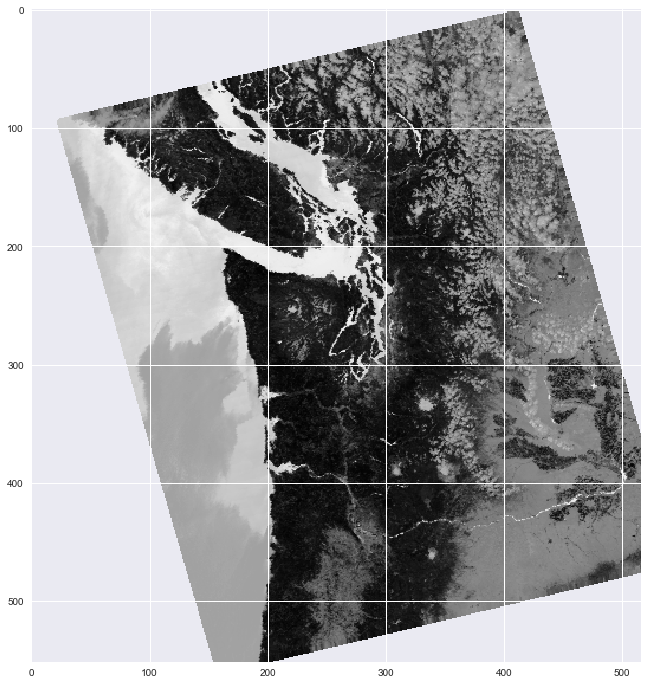

In [11]:
fig,ax=plt.subplots(1,1,figsize=(12,12))
ax.imshow(ndvi)

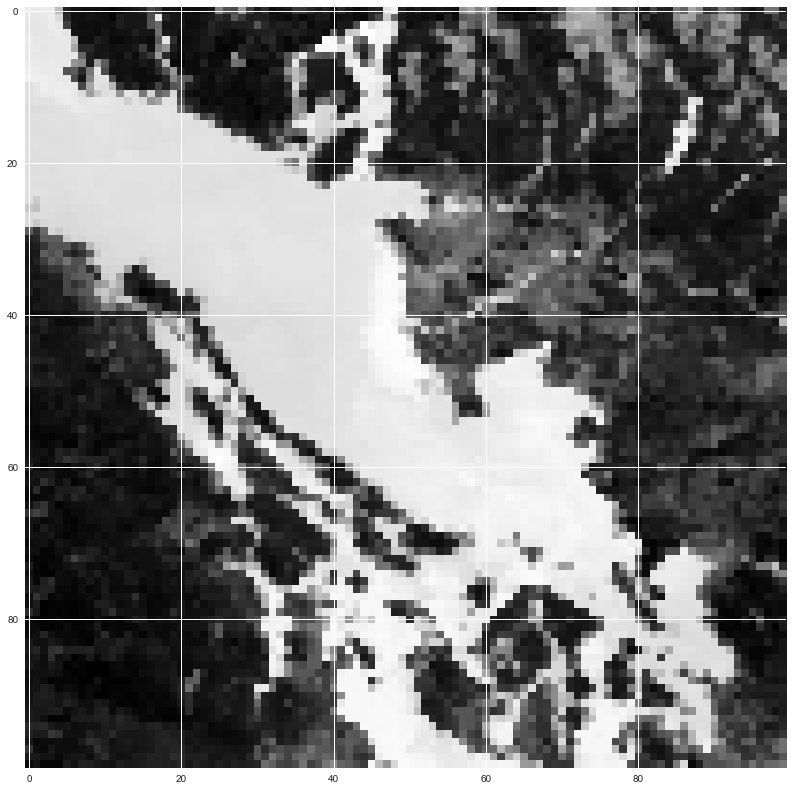

In [12]:
plt.close('all')
fig, ax = plt.subplots(1,1,figsize=(14,14))
ll_col=200
ll_row=200
ur_col=300
ur_row=100
ndvi_zoom=ndvi[ur_row:ll_row,ll_col:ur_col]
ax.imshow(ndvi_zoom);

In [13]:
from e582lib.geolocate import xy_to_col_row,col_row_to_xy

In [14]:
cmap=sns.diverging_palette(261, 153,sep=6, s=85, l=66,as_cmap=True)
vmin= -0.9
vmax=  0.9
cmap.set_over('c')
cmap.set_under('k',alpha=0.8)
cmap.set_bad('k',alpha=0.1)
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)

In [15]:
geotiff_args['adfgeotransform']
result_dict['basemap_args']

{'lat_0': 47.459999084472656,
 'llcrnrlat': 44.22774886587065,
 'llcrnrlon': -127.23767089843751,
 'lon_0': -122.78046417236328,
 'projection': 'laea',
 'rsphere': (6378137.0, 6356752.314245179),
 'urcrnrlat': 50.69224929516728,
 'urcrnrlon': -118.32325744628906}

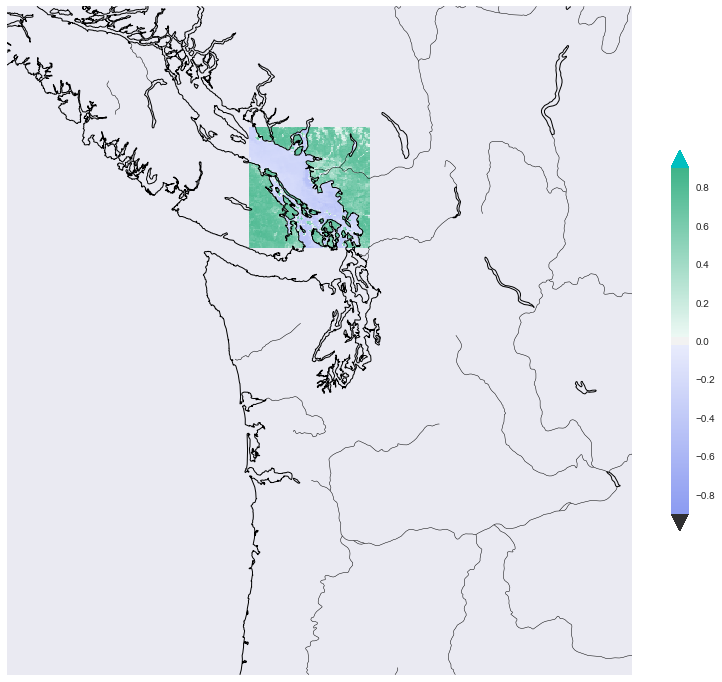

In [18]:
plt.close('all')
fig, ax = plt.subplots(1,1,figsize=(14,14))
basemap_args=result_dict['basemap_args']
basemap_args['ax'] = ax
basemap_args['resolution']='h'
bmap = Basemap(**basemap_args)
top_row=np.arange(ll_col,ur_col,dtype=np.int)
left_col=np.arange(ur_row,ll_row,dtype=np.int)



xline=np.empty(top_row.shape,dtype=np.float)
yline=np.empty(left_col.shape,dtype=np.float)
for index,colnum in enumerate(top_row):
    x,y=col_row_to_xy(colnum,ur_row,geotiff_args['adfgeotransform'])
    xline[index] = x
for index,rownum in enumerate(left_col):
    x,y=col_row_to_xy(ll_col,rownum,geotiff_args['adfgeotransform'])
    yline[index]=y
xline = xline + bmap.projparams['x_0']
yline = yline + bmap.projparams['y_0']
xvals, yvals = np.meshgrid(xline,yline)
col=bmap.pcolormesh(xvals,yvals,ndvi_zoom,cmap=cmap,norm=the_norm)
colorbar=bmap.ax.figure.colorbar(col, shrink=0.5, pad=0.05,extend='both')
bmap.drawcoastlines();
bmap.drawrivers();